In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys


sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/RingData/')

from DiffCorr import DiffCorr

In [2]:
f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/gai_filtered/GDP_buf/run108_PCA-denoise2.h5','r')
print f.keys()
print f['q10'].keys()

[u'q10', u'q11', u'q12', u'q13', u'q14', u'q15', u'q16', u'q17', u'q18', u'q19', u'q20', u'q21', u'q22', u'q23', u'q24', u'q25', u'q26', u'q27', u'q28', u'q29', u'q30', u'q31', u'q32']
[u'explained_variance_ratio', u'num_shots', u'pca0', u'pca1', u'pca10', u'pca11', u'pca12', u'pca13', u'pca14', u'pca15', u'pca2', u'pca3', u'pca4', u'pca5', u'pca6', u'pca7', u'pca8', u'pca9', u'pca_components']


In [3]:
f['q10']['pca3']['train_difcor']

<HDF5 dataset "train_difcor": shape (1, 326), type "<f8">

In [4]:
def get_cors(run_num, sample):
    #get mask used for run
    f_mask = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/combined_tables/gai/run%d.tbl'%run_num,'r')

    mask = f_mask['polar_mask_binned'].value
    mask = (mask==mask.max())
    mask.shape
    qs = np.linspace(0,1,mask.shape[0])
    dc=DiffCorr(mask[None,:,:],qs,0,pre_dif=True)
    mask_cor = dc.autocorr().mean(0)
    
    f_mask.close()
    
    f= h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/gai_filtered/%s/run%d_PCA-denoise2.h5'%(sample,run_num),'r')
    print f
    cors=[]
    all_cors=[]
    qinds= sorted([int(kk.split('q')[-1]) for kk in f.keys()])
    
    for qidx in qinds:
        cors=[]
        for ii in range(15):
            cors.append(f['q%d'%qidx]['pca%d'%ii]['train_difcor'].value[0]/mask_cor[qidx])
        cors=np.array(cors)

        all_cors.append(cors)
    all_cors=np.array(all_cors)
    num_shots=f['q14']['num_shots'].value
    f.close()
    
    return num_shots,all_cors

def average_norm_cor(run_nums,sample, num_phi = 326,phi_offset=15):
    all_num_shots=None
    all_cors=None
    
    for nn in run_nums:
#         print nn
        num_shots,cors=get_cors(nn, sample)
        
        if all_num_shots is None:
            all_num_shots=num_shots
            all_cors=cors*num_shots
        else:
            all_num_shots+=num_shots
            all_cors+=cors*num_shots
    return all_num_shots, all_cors/all_num_shots

def average_cors_with_low_asym(run_nums,sample, num_phi = 326,phi_offset=15):
    all_num_shots=None
    all_cors=None
    all_pca_nums=[]
   
    
    for nn in run_nums:
#         print nn
        num_shots,cors=get_cors(nn, sample)
        
        #get assym
        asyms=np.zeros((cors.shape[0],cors.shape[1]))

        for ii in range(pro_cors.shape[1]):
            asyms[:,ii]=compute_asym(cors[:,ii,:],phi_offset=phi_offset, norm=True)
        inds_selected = asyms[:,1:10].argmin(-1)
        
        if all_num_shots is None:
            all_num_shots=num_shots
            all_cors=np.array([cors[qq,jj,:] for qq,jj in enumerate(inds_selected)])*num_shots
        else:
            all_num_shots+=num_shots
            all_cors+=np.array([cors[qq,jj,:] for qq,jj in enumerate(inds_selected)])*num_shots
        all_pca_nums.append(inds_selected)
    
            
    return all_num_shots, all_cors/all_num_shots, np.array(all_pca_nums)
    
def normalize_set(d):
    x=d.copy()
    x-=x.min(-1)[:,None]
    return x/(x.max(-1)[:,None])

def compute_asym(corr, phi_offset=10,num_phi=326, norm = True):
    if norm:
        asym = (normalize_set(corr[:,phi_offset:num_phi/2-phi_offset])\
                      -normalize_set(corr[:,num_phi/2+phi_offset:-phi_offset]) )
    else:
        asym=(corr[:,phi_offset:num_phi/2-phi_offset]\
                      -corr[:,num_phi/2+phi_offset:-phi_offset])\
        /(corr[:,phi_offset:num_phi/2-phi_offset].max()\
          -corr[:,num_phi/2+phi_offset:-phi_offset].min())
        
    return np.mean(asym**2, axis=-1)**0.5

def normalize(d):
    x=d.copy()
    x-=x.min()
    return x/(x.max())

def save_num_pca(run_num,sample,num_pca, delete=False):
    
    f= h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/gai_filtered/%s/run%d_PCA-denoise.h5'%(sample,run_num),'a')
    qkeys=[kk for kk in f.keys() if kk.startswith('q')]
    inds=[int(kk.split('q')[-1]) for kk in qkeys]
    order = np.argsort(inds)
    qkeys=np.array(qkeys)[order]
    
    for ii, qk in enumerate(qkeys):
        n_p=num_pca[ii]
        grp=f[qk]
        if 'num_pca_cutoff' in grp.keys():
            if delete:
                grp.__delitem__('num_pca_cutoff')
            else:
                print('already save for %s'%qk)
                continue
        
        grp.create_dataset('num_pca_cutoff',data=n_p)
    f.close()

In [5]:
phi_offset=30
num_phi = 354
GDP_pro_nums=[121]
pro_num,pro_cors=average_norm_cor(GDP_pro_nums,'ALF_pro', phi_offset=phi_offset)

pro_asyms=np.zeros((pro_cors.shape[0],pro_cors.shape[1]))
pro_norm_cors = np.zeros_like(pro_cors[:,:,phi_offset:num_phi/2-phi_offset])

for ii in range(pro_cors.shape[1]):
    pro_asyms[:,ii]=compute_asym(pro_cors[:,ii,:],phi_offset=phi_offset, norm=True)
    pro_norm_cors[:,ii] = normalize_set(pro_cors[:,ii,phi_offset:num_phi/2-phi_offset])
    
GDP_buf_nums=[122]
buf_num,buf_cors=average_norm_cor(GDP_buf_nums,'ALF_buf', phi_offset=phi_offset)

buf_asyms=np.zeros((buf_cors.shape[0],buf_cors.shape[1]))
buf_norm_cors = np.zeros_like(buf_cors[:,:,phi_offset:num_phi/2-phi_offset])

for ii in range(buf_cors.shape[1]):
    buf_asyms[:,ii]=compute_asym(buf_cors[:,ii,:],phi_offset=phi_offset, norm=True)
    buf_norm_cors[:,ii] = normalize_set(buf_cors[:,ii,phi_offset:num_phi/2-phi_offset])

#select by asymmetry for every run
_,pro_cors2, pro_pca_nums=average_cors_with_low_asym(GDP_pro_nums,'ALF_pro', phi_offset=phi_offset)

pro_asyms2=compute_asym(pro_cors2,phi_offset=phi_offset, norm=True)
pro_norm_cors2 = normalize_set(pro_cors2[:,phi_offset:num_phi/2-phi_offset])

_,buf_cors2, buf_pca_nums=average_cors_with_low_asym(GDP_buf_nums,'ALF_buf', phi_offset=phi_offset)

buf_asyms2=compute_asym(buf_cors2,phi_offset=phi_offset, norm=True)
buf_norm_cors2 = normalize_set(buf_cors2[:,phi_offset:num_phi/2-phi_offset])

<HDF5 file "run121_PCA-denoise2.h5" (mode r)>
<HDF5 file "run122_PCA-denoise2.h5" (mode r)>
<HDF5 file "run121_PCA-denoise2.h5" (mode r)>
<HDF5 file "run122_PCA-denoise2.h5" (mode r)>


In [6]:
print pro_pca_nums
print buf_pca_nums

[[0 8 0 1 0 0 2 5 0 1 0 4 3 1 0 4 3 0 0 8 4 7 1]]
[[1 7 6 3 0 0 1 2 0 0 2 8 1 0 3 0 0 7 0 2 2 0 2]]


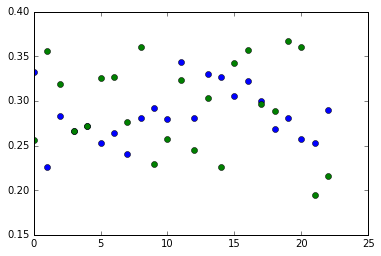

In [7]:
plt.plot(buf_asyms2,'o')
plt.plot(pro_asyms2,'o')

In [8]:
norm_diff=pro_norm_cors-buf_norm_cors
norm_diff2=pro_norm_cors2-buf_norm_cors2
diff=pro_cors-buf_cors
diff2=pro_cors2-buf_cors2
diff_norm_cors = np.zeros_like(buf_cors[:,:,phi_offset:num_phi/2-phi_offset])
diff_norm_cors2 = normalize_set(diff2[:,phi_offset:num_phi/2-phi_offset])
diff_asyms=np.zeros((buf_cors.shape[0],buf_cors.shape[1]))
norm_diff_asyms=np.zeros((buf_cors.shape[0],buf_cors.shape[1]))

for ii in range(buf_cors.shape[1]):
    diff_asyms[:,ii]=compute_asym(diff[:,ii,:],phi_offset=phi_offset, norm=True)
#     norm_diff_asyms[:,ii]=compute_asym(norm_diff[:,ii,:],
#     phi_offset=phi_offset, num_phi=norm_diff.shape[-1],
#     norm=True)
    diff_norm_cors[:,ii] = normalize_set(diff[:,ii,phi_offset:num_phi/2-phi_offset])
min_asym=diff_asyms[:,:10].argmin(-1)
# min_norm_asym=diff_asyms[:,:10].argmin(-1)

In [9]:
# np.save('no_calibration_pca0_gai_ALF.npy', diff)

In [8]:
print min_asym
pro_pca_nums.mean(0)


[0 4 0 0 2 1 3 2 3 1 5 9 3 2 3 1 0 5 1 0 0 1 7]


array([ 0.,  8.,  0.,  1.,  0.,  0.,  2.,  5.,  0.,  1.,  0.,  4.,  3.,
        1.,  0.,  4.,  3.,  0.,  0.,  8.,  4.,  7.,  1.])

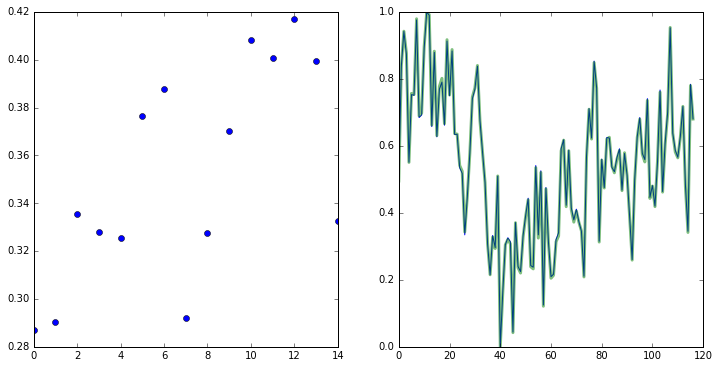

In [9]:
qidx = 0
nn=1
plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(diff_asyms[qidx,:],'o')
plt.subplot(122)
plt.plot(diff_norm_cors[qidx,nn])

plt.plot(normalize(norm_diff[qidx,nn]) , linewidth=3,alpha=0.5)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.10/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


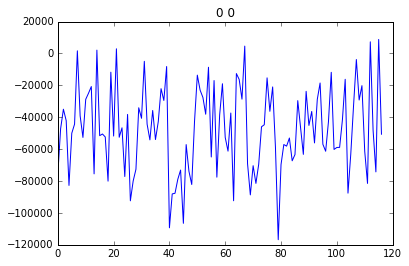

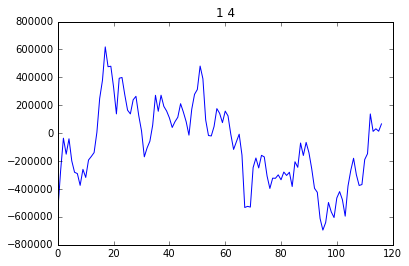

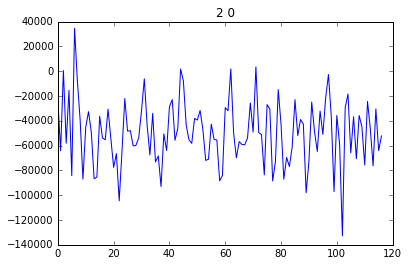

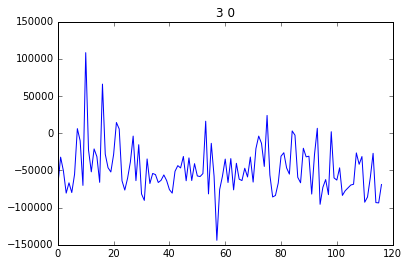

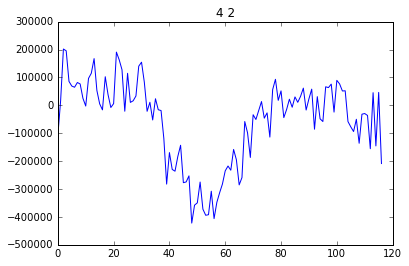

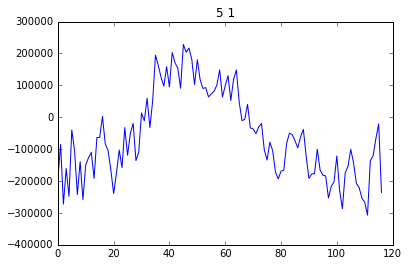

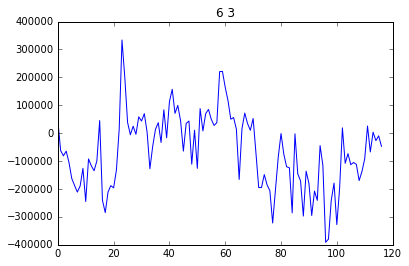

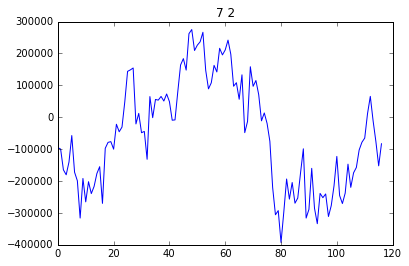

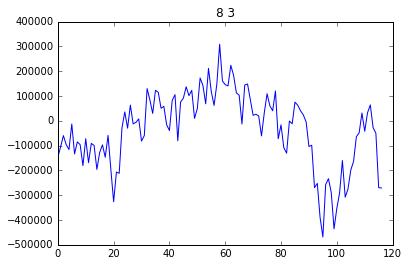

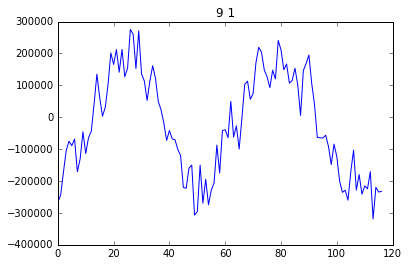

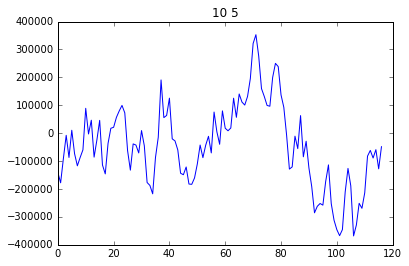

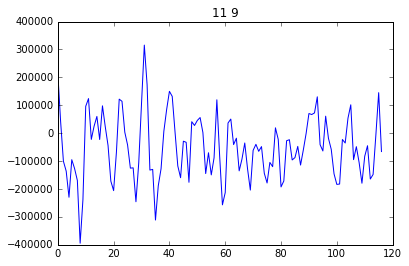

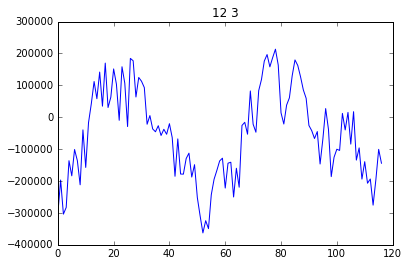

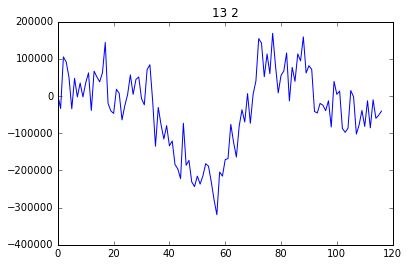

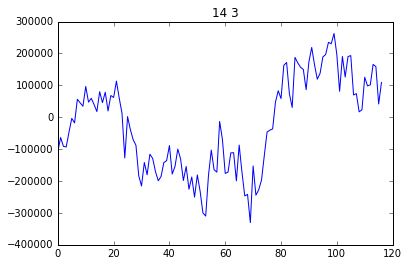

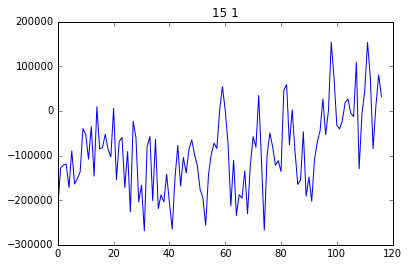

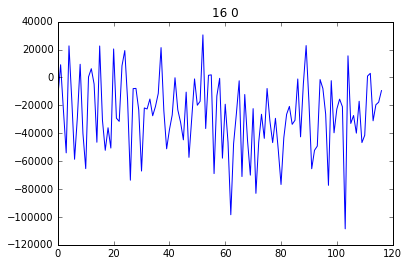

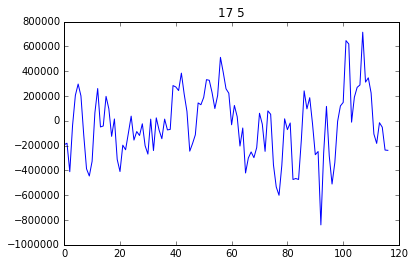

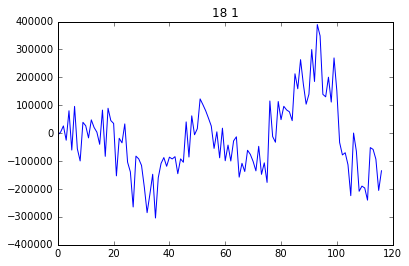

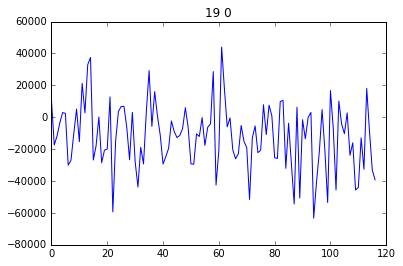

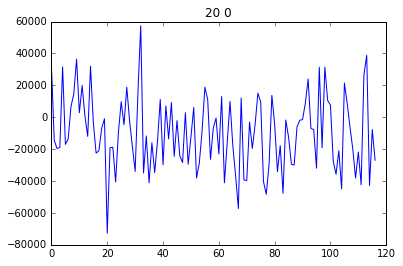

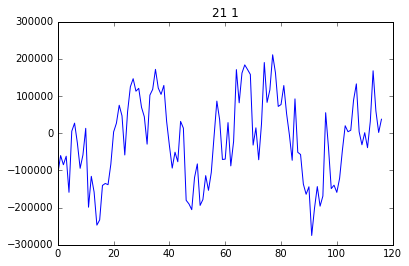

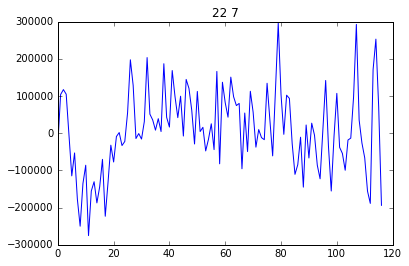

In [10]:
norm_diff.shape
min_asym.shape
x = np.array([diff[iq,ii,:] for iq,ii in enumerate(min_asym)])
x.shape
# diff
for qidx in range(23):
    plt.figure()
    plt.title("%d %d"%(qidx, min_asym[qidx]) )
    plt.plot(x[qidx,phi_offset:num_phi/2-phi_offset])

In [14]:
np.save('no_calibration_gai_ALF.npy',x)

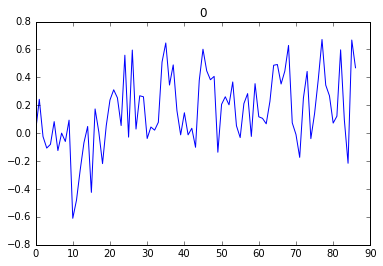

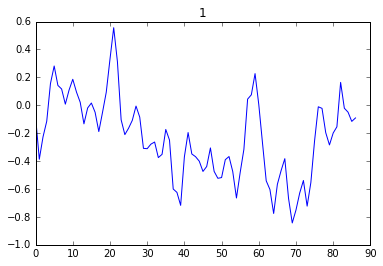

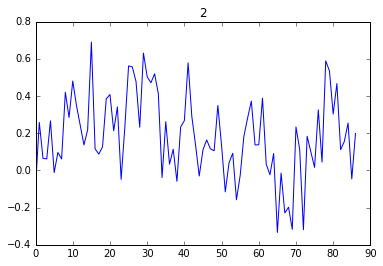

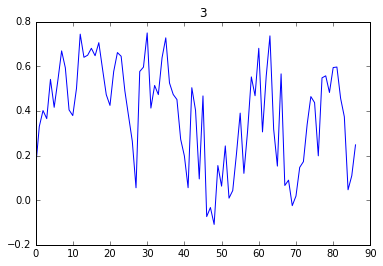

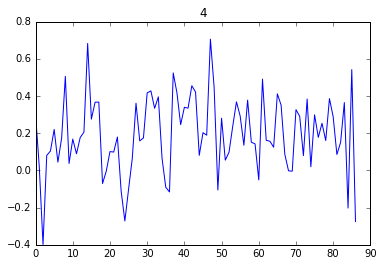

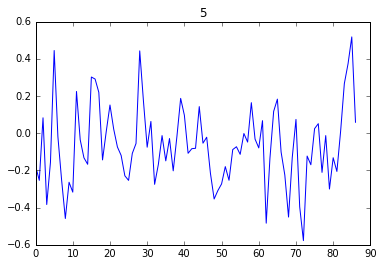

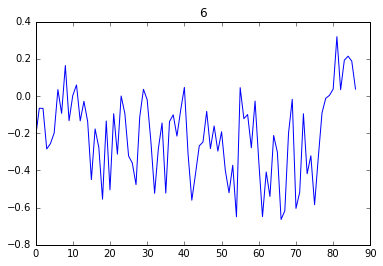

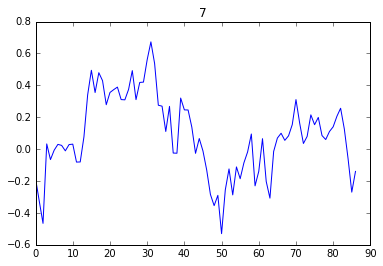

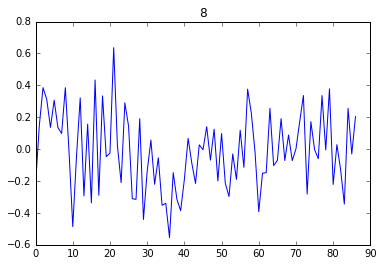

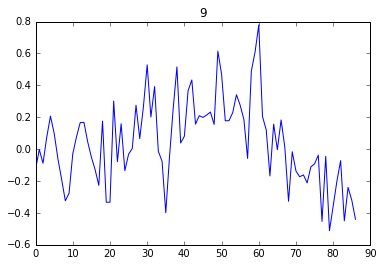

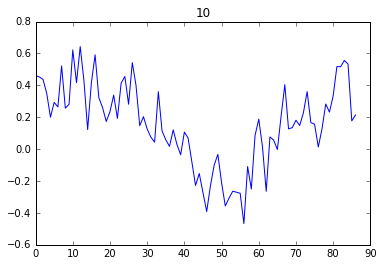

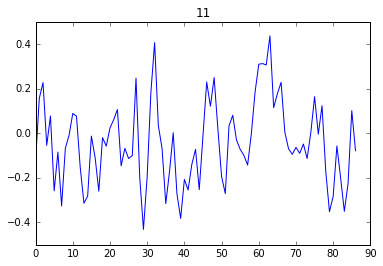

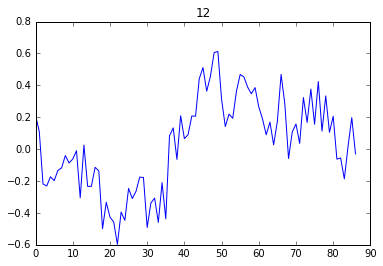

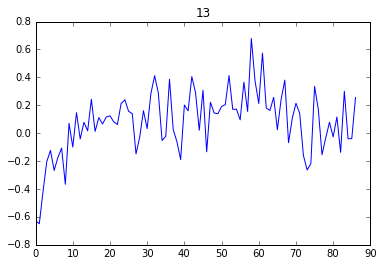

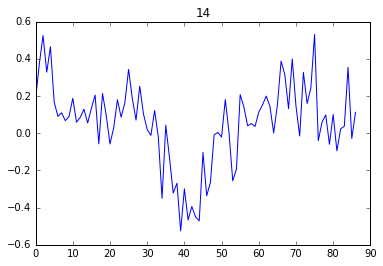

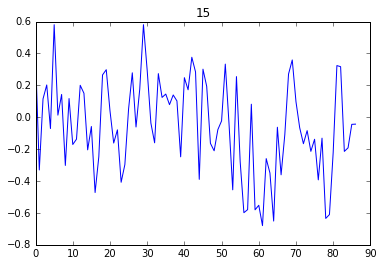

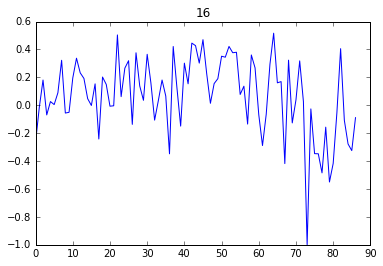

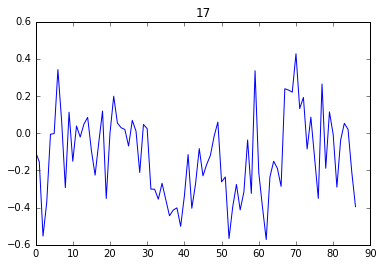

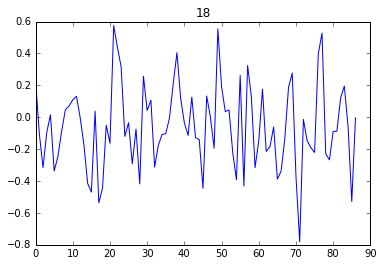

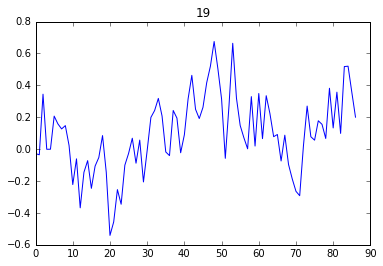

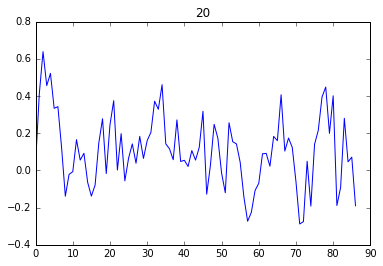

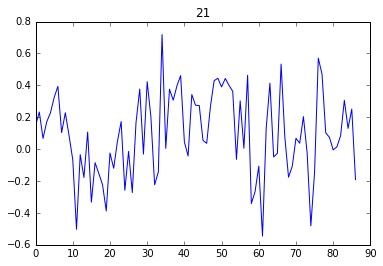

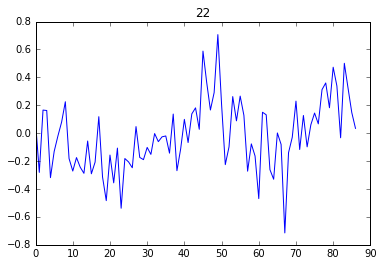

In [11]:
for qidx in range(23):
    plt.figure()
    plt.title(qidx)
    plt.plot(norm_diff2[qidx,phi_offset:num_phi/2-phi_offset])

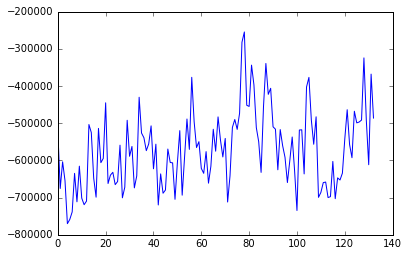

In [52]:
num_phi = 326
phi_offset=15
qidx = 22
nn = 4
plt.plot(cors[qidx,nn,phi_offset:num_phi/2-phi_offset])

In [17]:
cors.shape

(23, 15, 326)